In [1]:
#Choosing training/validation for Y3

#50/50 : start with 150 deg^2, 250 deg^2, 350 deg^2 – converge on limit for size
#*Random selection of parts of 624deg^2 to show invariance or not
#**reserve part of overlap region for science**

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

%load_ext autoreload
%autoreload 2

#for only galaxies: EXTENDED_CLASS_MASH_SOF = 3 apply this cut (this is the same as Y1 MODEST cut)

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
sys.path.append('../')
from xd import *
from run_DMASS import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io

In [3]:
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3


In [4]:
from xdgmm import XDGMM as XDGMM_Holoien

In [5]:
def _FindOptimalN_with_err( N, Xdata, Xcov, pickleFileName = None, suffix = None):
    #from sklearn.mixture import GMM
    #data, _ = mixing_color(data, suffix = suffix)
    @pickle_results( pickleFileName )
    def compute_GMM( N, covariance_type='full', n_iter=1000):
        models = [None for n in N]
        for i in range(len(N)):
            sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                             .format(i * 1./len(N) * 100.))
            sys.stdout.flush()
            models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter,
                            covariance_type=covariance_type)
            models[i].fit(Xdata, Xcov)
        return models
    
    models = compute_GMM(N)
    AIC = [m.aic(Xdata) for m in models]
    BIC = [m.bic(Xdata) for m in models]
    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                     .format(100))
    print("\nbest fit converged:", gmm_best.converged_, end=' ')
    print(" n_components =  %i" % N[i_best])
    return N[i_best], AIC, BIC

In [6]:
def XDnew_fitting_X( X = None, Xcov=None, 
        FileName = None, 
        #init_params = None, 
        #suffix='', 
        #mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        #filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, method='Bovy', verbose=False ):

    

    try: 
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj
    except FileNotFoundError: pass
    
    if X is None:
        # calling pre-computed model
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj

    else: 
        if n_cl == None : 
            param_range=np.arange(2, 50, 2)
            optimal_n_comp,_,_= _FindOptimalN_with_err( param_range, X, Xcov, 
            pickleFileName = FileName+'.n_cluster' , suffix = '')
            
            #xdgmm_test = XDGMM_Holoien( n_iter=n_iter, tol=tol, method=method )
            ## Define the range of component numbers, and get ready to compute the BIC for each one:
            #param_range = np.arange(2, 50, 2)
            ## Loop over component numbers, fitting XDGMM model and computing the BIC:
            #bic, optimal_n_comp, lowest_bic = xdgmm_test.bic_test(X, Xcov, param_range)
            ##n_cl = optimal_n_comp[np.argmin(bic)]
        else: optimal_n_comp = n_cl

        #import time
        # fitting
        #initiated class
        xdgmm_obj = XDGMM_Holoien( n_components=optimal_n_comp, n_iter=n_iter, tol=tol, method=method )
        #xdgmm.n_components = optimal_n_comp
        print ('n_components=', optimal_n_comp)
        print ('fitting started. This will take for a while.')
#        t1 = time.time()
        xdgmm_obj = xdgmm_obj.fit(X, Xcov)
        #t2 = time.time()
        print ('fitting finished')
        
        #t3 = time.time()
        print ('saving xdgmm object to.. ', FileName)
        xdgmm_obj.save_model(FileName)
        print ('file saved')
        #print ('saving obj. time:', (t3-t2)%60,'s')
        
        #t4 = time.time()
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        #print ('loading obj. time:', (t4-t3)%60,'s')
#        t2 = time.time()
#        print ('elapsed time:', (t2-t1)/60.0,'s')
        return xdgmm_obj

In [7]:
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASSY3/code_py3


In [8]:
'''# calling map 
path = '/fs/scratch/PCON0003/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix
'''

"# calling map \npath = '/fs/scratch/PCON0003/warner785/bwarner/'\nLSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')\n# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'\n#GoldMask = callingEliGoldMask()\nLSSMask = LSSGoldmask\nGoldMask = LSSGoldmask\n\npixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)\n\nLSSMask = LSSMask[pixdec >-3.0 ]\n#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)\nGoldMask_st82 = GoldMask[ pixdec > -3.0 ]\nGoldMask_spt = GoldMask[ pixdec < -3.0 ]\n#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)\n\npixarea = hp.nside2pixarea( 4096, degrees = True)\nsptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )\nst82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )\nSPTMaparea = pixarea * sptnpix\nST82Maparea = pixarea * st82npix\n"

In [9]:
# call required functions from modules 

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000125.fits
Y3_GOLD_2_0_STRIPE82_000136.fits
Y3_GOLD_2_0_STRIPE82_000040.fits
Y3_GOLD_2_0_STRIPE82_000015.fits
Y3_GOLD_2_0_STRIPE82_000086.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000108.fits
Y3_GOLD_2_0_STRIPE82_000079.fits
Y3_GOLD_2_0_STRIPE82_000076.fits
Y3_GOLD_2_0_STRIPE82_000057.fits
Y3_GOLD_2_0_STRIPE82_000111.fits
Y3_GOLD_2_0_STRIPE82_000084.fits
Y3_GOLD_2_0_STRIPE82_000088.fits
Y3_GOLD_2_0_STRIPE82_000049.fits
Y3_GOLD_2_0_STRIPE82_000063.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000077.fits
Y3_GOLD_2_0_STRIPE82_000042.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000115.fits
Y3_GOLD_2_0_STRIPE82_000028.fits
Y3_GOLD_2_0_STRIPE82_000140.fits
Y3_GOLD_2_0_STRIPE82_000060.fits
Y3_GOLD_2_0_STRIPE82_000089.fits
Y3_GOLD_2_0_STRIPE82_000143.fits
Y3_GOLD_2_0_STRIPE82_000012.fits
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000137.fits
Y3_GOLD_2_0_STRIPE82_

In [10]:
#this CMASS used for Y1, and Y3 now:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
gold_st82_train = gold_st82[mask]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

print(('num of cmass in des side', clean_cmass_data_des_train.size, '({:0.0f}%)'.format(clean_cmass_data_des_train.size*1./cmass.size*100.)))

#gold_st82 = None
#train_sample = None
'''
healConfig={'out_nside':64, 'nest':True}

train_sample = HealPixifyCatalogs(catalog=clean_cmass_data_des_train, healConfig=healConfig, ratag='RA', dectag = 'DEC')
gold_st82 = HealPixifyCatalogs(catalog=gold_st82_train, healConfig=healConfig, ratag='RA', dectag = 'DEC')

#numbers slightly off: odd 6325  even 6314 -- from Su
#total healpix number is larger --- proportional to area, therefore larger area --- mask is different-- masking less of region
evenmask_train = train_sample['HEALIndex']%2 == 0
evenmask = gold_st82['HEALIndex']%2 == 0

pixarea = hp.nside2pixarea( 64, degrees = True)
print('odd', np.sum(evenmask_train), ' even', np.sum(~evenmask_train))
print('area', 'odd', np.sum(evenmask_train)*pixarea, ' even', np.sum(~evenmask_train)*pixarea)
print(pixarea)

GoldMask_st82_hpix64 = HealPixifyCatalogs(catalog=gold_st82, healConfig=healConfig, ratag='RA', dectag = 'DEC')
ringhpindex = hp.nest2ring(4096, [GoldMask_st82_hpix64['HEALIndex']])
evenmask_map = ringhpindex%2 == 0 
#pixarea64 = hp.nside2pixarea( 64, degrees = True)

print('odd', np.sum(evenmask_map), ' even', np.sum(~evenmask_map))
print('area', 'odd', np.sum(evenmask_map)*pixarea, ' even', np.sum(~evenmask_map)*pixarea)
# area odd 62.36836976435403  even 62.522253926354416

GoldMask_st82_hpix64.size

train_even = train_sample[evenmask_train]
train_odd = train_sample[~evenmask_train]
gold_st82_even = gold_st82[evenmask]
gold_st82_odd = gold_st82[~evenmask]

# Directory doesn't exist ---- create 
# check for error: print statement 
import os
outdir = '../output/validate_NEST/'
if os.path.exists(outdir) == False:
    os.mkdir(outdir)
rootdir2 = '../output/validate_NEST/'

fitsio.write(rootdir2+'train_NEST_even.fits', train_even, clobber=True)
fitsio.write(rootdir2+'train_NEST_odd.fits', train_odd, clobber=True)

fitsio.write(rootdir2+'gold_st82_NEST_even.fits', gold_st82_even, clobber=True)
fitsio.write(rootdir2+'gold_st82_NEST_odd.fits', gold_st82_odd, clobber=True)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_even['RA'], train_even['DEC'], gold_st82_even['RA'], \
                                     gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask_even = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask_even[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask_even], gold_st82_even[~cmass_mask_even]
print('cmass_fraction even', clean_cmass_data_des_even.size *1./gold_st82_even.size)
fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size

mg1, mg2, _ = esutil.htm.HTM(10).match(train_odd['RA'], train_odd['DEC'], gold_st82_odd['RA'], \
                                     gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask_odd = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask_odd[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask_odd], gold_st82_odd[~cmass_mask_odd]
print('cmass_fraction odd', clean_cmass_data_des_odd.size *1./gold_st82_odd.size)
fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

gold_st82 = None
train_sample = None

'''

import numpy as np
nocmass_random_ind = np.random.choice(np.arange(nocmass_train.size), size = int(nocmass_train.size/5))
nocmass_random = nocmass_train[nocmass_random_ind] 

print(nocmass_random.size)
print(clean_cmass_data_des_train.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031
('num of cmass in des side', 13193, '(5%)')
235786
13193


In [ ]:
'''#(old method: do not run)

cmass_pickle = rootdir2+'gold_st82_XD_cmass_even_Y3.pkl'
clf_cmass_st82=XD_fitting( data = clean_cmass_data_des_even, pickleFileName = cmass_pickle, init_params = None, n_cl = None, n_iter = 10000, tol = 1e-5, verbose = True)

no_pickle = rootdir2+'gold_st82_XD_no_even_Y3.pkl'
#init_pickle = rootdir2+'gold_st82_XD_no_NEST_even.pkl'# '../output/sfd_train_photo_SamPle_nozband_ran10_3/gold_st82_XD_no.pkl'
init_pickle = None
clf_no_st82 = XD_fitting( data = nocmass_random, pickleFileName = no_pickle , init_params = None, 
                    n_cl = None, n_iter = 20000, tol = 1e-5, verbose = True)
                    '''

In [11]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 10000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_gold_bovyY3_130SOF_unfixed.xdgmm'

In [12]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [13]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovyY3_130fixed.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  6


In [13]:
# Fitting start with Bovy's method
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = 12, n_iter = n_iter_gold, tol = tol, method='Bovy')

Using precomputed results from  output/test/fitting/gauss_gold_bovyY3_130SOF_unfixed.xdgmm


In [14]:
#Next: noncmass data

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_nogold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_nogold = 15000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_nogold_bovyY3_130SOF_unfixed3.xdgmm'

In [15]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_nogold, X_nogold_cov = mixing_color(nocmass_random, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [17]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_nogold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_nogold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_nogold_bovyY3_130fixed.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  42


In [ ]:
# Fitting start with Bovy's method
clf_nogold = XDnew_fitting_X( X_nogold, X_nogold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = 48, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 48
fitting started. This will take for a while.


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


In [19]:
#testing figure 3
#gold_st82=None
#train_sample=None

In [11]:
#load in:
#clf_nodmass = clf_nogold 
#clf_dmass = clf_gold
#clf_dmass = np.load('output/test/fitting/gauss_gold_bovyY3_130fixed.xdgmm', allow_pickle=True)
#clf_nodmass = np.load('output/test/fitting/gauss_nogold_bovyY3_130fixed.xdgmm', allow_pickle=True)

#xdgmm = XDGMM()
clf_dmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130SOF_unfixed.xdgmm')
clf_nodmass = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_130SOF_unfixed3.xdgmm')

In [19]:
#different colors
'''
mag = ['MOF_CM_MAG_CORRECTED', 'MOF_CM_MAG_CORRECTED' ]
err = ['MOF_CM_MAG_ERR', 'MOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

'MAG_DETMODEL_R'
'''

'MAG_DETMODEL_R'

In [20]:
'''
#Y3 Data

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio

%matplotlib inline

%load_ext autoreload
%autoreload 2

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test
'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
'''
# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]
'''


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000125.fits
Y3_GOLD_2_0_STRIPE82_000136.fits
Y3_GOLD_2_0_STRIPE82_000040.fits
Y3_GOLD_2_0_STRIPE82_000015.fits
Y3_GOLD_2_0_STRIPE82_000086.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000108.fits
Y3_GOLD_2_0_STRIPE82_000079.fits
Y3_GOLD_2_0_STRIPE82_000076.fits
Y3_GOLD_2_0_STRIPE82_000057.fits
Y3_GOLD_2_0_STRIPE82_000111.fits
Y3_GOLD_2_0_STRIPE82_000084.fits
Y3_GOLD_2_0_STRIPE82_000088.fits
Y3_GOLD_2_0_STRIPE82_000049.fits
Y3_GOLD_2_0_STRIPE82_000063.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000077.fits
Y3_GOLD_2_0_STRIPE82_000042.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000115.fits
Y3_GOLD_2_0_STRIPE82_000028.fits
Y3_GOLD_2_0_STRIPE82_000140.fits
Y3_GOLD_2_0_STRIPE82_000060.fits
Y3_GOLD_2_0_STRIPE82_000089.fits
Y3_GOLD_2_0_STRIPE82_000143.fits
Y3_GOLD_2_0_STRIPE82_000012.fits
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000137.fits
Y3_GOLD_2_0_STRIPE82_

In [22]:
'''
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)
'''

6867149
5757776


In [23]:
#this CMASS used for Y1, and Y3 now:
'''
import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)
'''

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [13]:
#(Validation 1) Figure 3

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

cmass_fraction_full = clean_cmass_data_des_train.size *1./gold_st82_train.size
print(cmass_fraction_full)

mask4 =(gold_st82['RA']>15)&(gold_st82['RA']<41)
mask4 = mask4 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v4 = gold_st82[mask4]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v4['RA'], \
                                         gold_st82_v4['DEC'],2./3600, maxmatch=1)
cmass_mask4 = np.zeros(gold_st82_v4.size, dtype=bool)
cmass_mask4[mg2] = 1
clean_cmass_data_des_v4, nocmass_v4 = gold_st82_v4[cmass_mask4], gold_st82_v4[~cmass_mask4]

clean_dmass_prob4 = assignCMASSProb(clean_cmass_data_des_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real4 = clean_dmass_prob4

dmass_st82_val4 = assignCMASSProb(gold_st82_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real4['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val4['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
#fracerr = (N/M)*np.sqrt((1/N)-(1/M))

x1=frac
x2=pcenter
err=fracerr
diff2 = (x1-x2)**2 
diff2_reduced = sum(diff2)/diff2.size
print("diff2_reduced: ",diff2_reduced)
print("size: ",diff2.size)
print("sum of diff2: ",sum(diff2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region Check 100%')
fig.savefig('SOF_Val_new_check.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

0.01106678320915742
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00091752 0.08167416 0.13745632 0.18238392 0.24438903 0.29759798
 0.34156379 0.38655184 0.44732992 0.49372549 0.53842635 0.58474167
 0.66332856 0.68192656 0.71814672 0.78009709 0.81095492 0.84476715
 0.87339268 0.90636704]
diff2_reduced:  0.0006664063639354987
size:  20
sum of diff2:  0.013328127278709974


In [14]:
print(gold_st82.size)

AttributeError: 'NoneType' object has no attribute 'size'

In [41]:
#takes 20 percent of validation samples:
print(gold_st82_v1.size)
gold_v1_random_ind = np.random.choice(np.arange(gold_st82_v1.size), size = int(gold_st82_v1.size/5))
gold_v1_random = gold_st82_v1[gold_v1_random_ind]
print(gold_v1_random.size)

print(gold_st82_v2.size)
gold_v2_random_ind = np.random.choice(np.arange(gold_st82_v2.size), size = int(gold_st82_v2.size/5))
gold_v2_random = gold_st82_v2[gold_v2_random_ind]
print(gold_v2_random.size)

print(gold_st82_v3.size)
gold_v3_random_ind = np.random.choice(np.arange(gold_st82_v3.size), size = int(gold_st82_v3.size/5))
gold_v3_random = gold_st82_v3[gold_v3_random_ind]
print(gold_v3_random.size)

#match CMASS to random
mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_v1_random['RA'], \
                                         gold_v1_random['DEC'],2./3600, maxmatch=1)
cmass_mask1 = np.zeros(gold_v1_random.size, dtype=bool)
cmass_mask1[mg2] = 1
clean_cmass_data_des_v1, nocmass_v1 = gold_v1_random[cmass_mask1], gold_v1_random[~cmass_mask1]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_v2_random['RA'], \
                                         gold_v2_random['DEC'],2./3600, maxmatch=1)
cmass_mask2 = np.zeros(gold_v2_random.size, dtype=bool)
cmass_mask2[mg2] = 1
clean_cmass_data_des_v2, nocmass_v2 = gold_v2_random[cmass_mask2], gold_v2_random[~cmass_mask2]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_v3_random['RA'], \
                                         gold_v3_random['DEC'],2./3600, maxmatch=1)
cmass_mask3 = np.zeros(gold_v3_random.size, dtype=bool)
cmass_mask3[mg2] = 1
clean_cmass_data_des_v3, nocmass_v3 = gold_v3_random[cmass_mask3], gold_v3_random[~cmass_mask3]

2738505
547701
2761987
552397
2797778
559555


In [12]:
cmass_fraction_full = clean_cmass_data_des_train.size *1./gold_st82_train.size
print(cmass_fraction_full)

0.01106678320915742


In [33]:
'''
# ODD cmass fraction: use even as validation

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_even['RA'], \
                                         gold_st82_even['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_even.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_even, nocmass_even = gold_st82_even[cmass_mask], gold_st82_even[~cmass_mask]

print(nocmass_even.size)

print(('num of cmass in des side in training', clean_cmass_data_des_even.size, '({:0.0f}%)'.format(clean_cmass_data_des_even.size*1./cmass.size*100.)))
'''

473226
('num of cmass in des side in training', 5451, '(2%)')


In [34]:
'''
# EVEN cmass fraction: use odd as validation

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_odd['RA'], \
                                         gold_st82_odd['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(gold_st82_odd.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des_odd, nocmass_odd = gold_st82_odd[cmass_mask], gold_st82_odd[~cmass_mask]

print(nocmass_odd.size)

print(('num of cmass in des side in training', clean_cmass_data_des_odd.size, '({:0.0f}%)'.format(clean_cmass_data_des_odd.size*1./cmass.size*100.)))
'''

452713
('num of cmass in des side in training', 5151, '(2%)')


In [35]:
'''

cmass_fraction_even = clean_cmass_data_des_even.size *1./gold_st82_even.size
cmass_fraction_odd = clean_cmass_data_des_odd.size *1./gold_st82_odd.size

print(cmass_fraction_even)
print(cmass_fraction_odd)

'''

0.011387637174963492
0.011250065521639614


In [38]:
clf_nodmass = clf_nogold 
clf_dmass = clf_gold

In [13]:
#training region check

#mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
#mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
#gold_st82_train = gold_st82[mask]

print(gold_st82_train.size)
gold_train_random_ind = np.random.choice(np.arange(gold_st82_train.size), size = int(gold_st82_train.size/5))
gold_train_random = gold_st82_train[gold_train_random_ind]
print(gold_train_random.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

#clean_cmass_data_des = clean_cmass_data_des_train

clean_dmass_prob_train = assignCMASSProb(clean_cmass_data_des_train, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


dmass_st82_real_train = clean_dmass_prob_train # actual CMASS galaxies in train set
dmass_st82_val_train = assignCMASSProb(gold_st82_train, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real_train['CMASS_PROB'], bins=pbin)

import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val_train['CMASS_PROB'], bins=pbin)

frac = N/M
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr, label = str(sum(chi2)))
ax.plot([0,1], [0,1], ls='--', color='grey')
plt.title('Training Region Check 100%')
fig.savefig('test_histo_train.pdf')

1192126
238425
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
chi2_reduced:  0.24080490374153948
size:  20
sum of chi2:  4.81609807483079


In [33]:
#pois. error bar based on number of data points 
#possible:
#20% the error bars frac. are much larger, noiser data 
x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

chi2_reduced:  0.6969158383943347
size:  20
sum of chi2:  13.938316767886693


cmass fraction:  0.01106678320915742
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00087892 0.06896552 0.12062848 0.17589083 0.21475771 0.25226391
 0.31934033 0.34146341 0.38898757 0.41312741 0.49448124 0.57311321
 0.58133971 0.6107056  0.64       0.69247788 0.7443038  0.76190476
 0.79434447 0.78930818]
frac.size 20
frac err 20
[0.04622502 0.06131393 0.06482037 0.06565322 0.07161149 0.07161149
 0.06851887 0.06900656 0.06757374 0.06835859 0.06681531 0.06415003
 0.06415003 0.06311944 0.0625     0.05652334 0.05832118 0.05892557
 0.05688801 0.06311944]


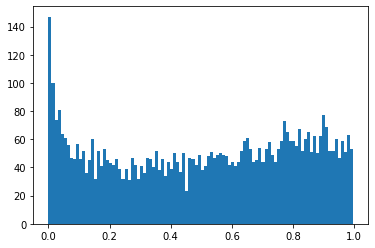

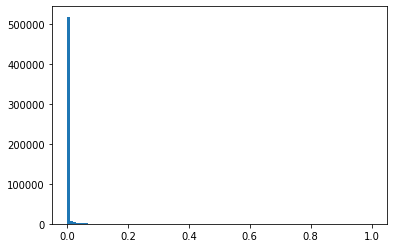

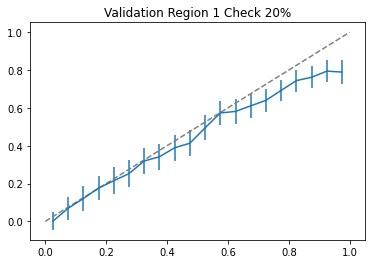

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

print('cmass fraction: ', cmass_fraction)
#(Validation 1) Figure 3
clean_dmass_prob1 = assignCMASSProb(clean_cmass_data_des_v1, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )
#dmass_st82 = io.SearchAndCallFits(path = rootdir, keyword='gold_st82_prob.fits')
#this is simply gold_st82 with all cuts made
#XD of y1 gold des in st82 -- with membership probability
dmass_st82_real1 = clean_dmass_prob1 # actual CMASS galaxies in val set

# all calculated DMASS for validation sets:

#for-loop? larger data set
dmass_st82_val1 = assignCMASSProb(gold_v1_random, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real1['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val1['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real1['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val1['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Validation Region 1 Check 20%')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo.pdf')

In [15]:
#(Validation 2) Figure 3

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v2['RA'], \
                                         gold_st82_v2['DEC'],2./3600, maxmatch=1)
cmass_mask2 = np.zeros(gold_st82_v2.size, dtype=bool)
cmass_mask2[mg2] = 1
clean_cmass_data_des_v2, nocmass_v2 = gold_st82_v2[cmass_mask2], gold_st82_v2[~cmass_mask2]

clean_dmass_prob2 = assignCMASSProb(clean_cmass_data_des_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real2 = clean_dmass_prob2

dmass_st82_val2 = assignCMASSProb(gold_st82_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real2['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val2['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
plt.title('Validation Region 2 Check 100%')
fig.savefig('SOF_Val100.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [8.77110979e-04 7.97692461e-02 1.34111364e-01 1.99635646e-01
 2.55855498e-01 3.09393638e-01 3.59940209e-01 4.15615411e-01
 4.52681388e-01 4.92497793e-01 5.52594670e-01 5.87398374e-01
 6.52910053e-01 6.90851735e-01 7.15940430e-01 7.51238305e-01
 8.26256983e-01 8.11031665e-01 8.68421053e-01 8.97199847e-01]
chi2_reduced:  1.9875534522119593
size:  20
sum of chi2:  39.75106904423919


calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00088755 0.06966887 0.13299492 0.18080357 0.20335637 0.27978581
 0.32041729 0.30870279 0.41103203 0.46259843 0.45263158 0.50707547
 0.58133333 0.6019656  0.65986395 0.71171171 0.77615572 0.71182266
 0.7686747  0.78082192]


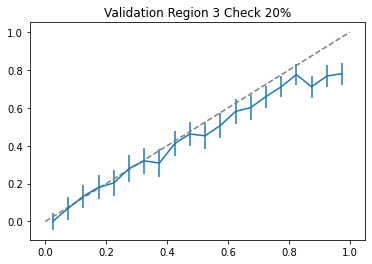

In [56]:
#(Validation 3) Figure 3

clean_dmass_prob3 = assignCMASSProb(clean_cmass_data_des_v3, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real3 = clean_dmass_prob3 

dmass_st82_val3 = assignCMASSProb(gold_v3_random, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real3['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val3['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
plt.title('Validation Region 3 Check 20%')

fig.savefig('test_histo3.pdf')

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pcenter 20
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [9.10660590e-04 6.84110112e-02 1.33442266e-01 1.57811261e-01
 2.27272727e-01 2.50996016e-01 3.16045381e-01 3.78870674e-01
 3.94273128e-01 4.85781991e-01 5.65552699e-01 5.92307692e-01
 6.58192090e-01 7.09424084e-01 7.36842105e-01 7.32590529e-01
 8.07792208e-01 8.96358543e-01 9.22897196e-01 9.53125000e-01]
frac.size 20
frac err 20
[0.04975186 0.06311944 0.06388766 0.07088812 0.07071068 0.0727393
 0.07161149 0.06933752 0.07474351 0.06984303 0.06741999 0.06579517
 0.06551218 0.06074567 0.06131393 0.06166264 0.0567048  0.0559017
 0.05031546 0.05227084]


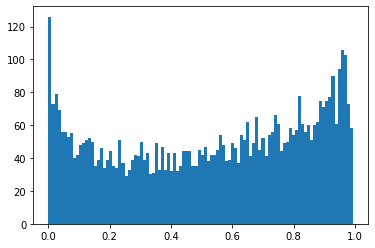

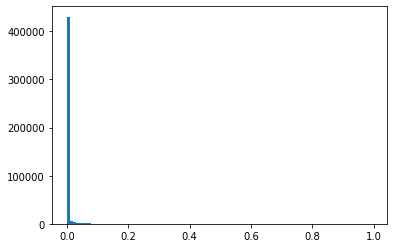

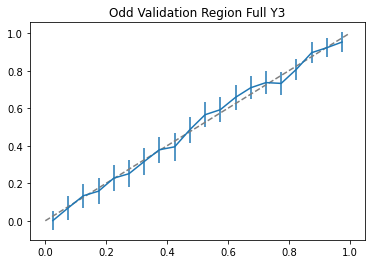

In [36]:
# Figure 3 start: Odd/Even Method
%matplotlib inline
import matplotlib.pyplot as plt

cmass_fraction = clean_cmass_data_des.size *1./gold_st82.size
#call in catalogs

clean_dmass_prob = assignCMASSProb(clean_cmass_data_des_odd, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

dmass_st82_real = clean_dmass_prob

dmass_st82_val = assignCMASSProb(gold_st82_odd, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_even
, 
                     mag=mag, err=err, filter=filter )

pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
print('pcenter',pcenter.size)
N, _ = np.histogram(dmass_st82_real['CMASS_PROB'], bins=pbin) # -- true cmass
print('pbin =', pbin)
M, _ = np.histogram(dmass_st82_val['CMASS_PROB'], bins=pbin) # -- dmass

fig, ax = plt.subplots()
ax.hist( dmass_st82_real['CMASS_PROB'], bins= 100)
fig, ax = plt.subplots()
ax.hist( dmass_st82_val['CMASS_PROB'], bins= 100)

#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

frac = N/M
print('frac = ', frac)
print('frac.size', frac.size)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
print('frac err', fracerr.size)
fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
plt.title('Validation Region Full Y3')
print(fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')

fig.savefig('test_histo_y3_full.pdf')

In [57]:
# save the samples. 
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_st82_val1_129.fits', dmass_st82_val1, overwrite=True)
esutil.io.write( outdir+'dmass_st82_val2_129.fits', dmass_st82_val2, overwrite=True)
esutil.io.write( outdir+'dmass_st82_val3_129.fits', dmass_st82_val3, overwrite=True)

In [59]:
import scipy

scipy.stats.chisquare(dmass_st82_val3['CMASS_PROB'], f_exp=dmass_st82_real3['CMASS_PROB'], ddof=0, axis=0)

ValueError: operands could not be broadcast together with shapes (559555,) (5247,) 

In [14]:
# color distributions

X_sample_dmass = clf_dmass.sample(200000)        # non-cmass model
X_sample_nodmass = clf_nodmass.sample(200000)

mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [15]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_sample_dmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'SOF_cmass.pdf')

Using central 100% to set range.


In [16]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_no_true, X_sample_nodmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'SOF_nocmass.pdf')

Using central 100% to set range.
